In [ ]:
!pip install pgmpy
!pip install pyro-ppl

# Coding random processes
Want to model the following joint probability distribution $P(x, y, z)$ assuming Y is conditionally independent of Z given X:
1.   Apply Chain Rule: $P(x, y, z)=P(z)P(x|z)P(y|x, z)$
2.   Apply Conditional Independence: $P(x, y, z)=P(z)P(x|z)P(y|x)$
3.   Sample from probability distributions:
      1.   $z\sim P(Z)$
      2.   $x\sim P(X|Z=z)$
      3.   $y\sim P(Y|X=x)$





In [ ]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.sampling import BayesianModelSampling

In [ ]:
# random process using pgmpy
# creating probability dirstributions
PZ = TabularCPD(     #1
    variable='Z',     #1
    variable_card=2,     #1
    values=[[.65], [.35]],     #1
    state_names = {     #1
        'Z': ['0', '1']     #1
    })     #1

PXgivenZ = TabularCPD(     #2
    variable='X',    #2
    variable_card=2,   #2
    values=[   #2
        [.8, .6],   #2
        [.2, .4],   #2
    ],    #2
    evidence=['Z'],    #2
    evidence_card=[2],  #2
    state_names = {    #2
        'X': ['0', '1'],    #2
        'Z': ['0', '1'] #2
    })   #2

PYgivenX = TabularCPD(     #3
    variable='Y',     #3
    variable_card=3,     #3
    values=[    #3
        [.1, .8],     #3
        [.2, .1],     #3
        [.7, .1],    #3
    ],    #3
    evidence=['X'],     #3
    evidence_card=[2],    #3
    state_names = {    #3
        'Y': ['1', '2', '3'],    #3
        'X': ['0', '1']    #3
    })    #3
# generating samples for x, y z
model = DiscreteBayesianNetwork([('Z', 'X'), ('X', 'Y')])
model.add_cpds(PZ, PXgivenZ, PYgivenX)
generator = BayesianModelSampling(model)
generator.forward_sample(size=1)

  0%|          | 0/3 [00:00<?, ?it/s]

,Z,X,Y
0,1,1,3


In [ ]:
# random process using pyro
import torch
from pyro.distributions import Bernoulli, Poisson, Gamma

z = Gamma(7.5, 1.0).sample()    #1
x = Poisson(z).sample()    #2
y = Bernoulli(x / (5+x)).sample()   #3
print(z, x, y)

tensor(10.4737) tensor(16.) tensor(0.)


In [ ]:
import pyro
def random_process():
    z = pyro.sample("z", Gamma(7.5, 1.0))
    x = pyro.sample("x", Poisson(z))
    y = torch.tensor(0.0)
    for i in range(int(x)):
        y += pyro.sample(f"y{i}", Bernoulli(.5))    #1
    return y
#print(random_process())
generated_samples = torch.stack([random_process() for _ in range(100)])
generated_samples.mean()

tensor(3.8900)

# Buiding a Causal DAG

Will be building a causal model using a causal DAG of people's choice of transportation on their daily commute with the following random variables and causal relationships/assumptions:

## Random Variables:
1.   *A* = The age of an individual
2.   *S* = An individuals reported gender
3.   *E* = An individual's level of education or training
4.   *O* = An individuals occupation
5.   *R* = The size of the city the individual resides in
6.   *T* = The means of transport favored by the individual

## Causal Relationships/Assumptions:
*   age is a cause of education (A→E)
*   gender is a cause of education (S→E)
*   education is a cause of occupation (E→O)
*   education is a cause of where people reside (E→R)
*   occupation is a cause of transportation (O→T)
*   residence is a cause of transportation (R→T)

In [ ]:
from pgmpy.models import DiscreteBayesianNetwork
import networkx as nx
# Building list of causal relationships
caus_real=[('A', 'E'),('S', 'E'),('E', 'O'),('E', 'R'),('O', 'T'),('R', 'T')]
# Building causal DAG from causal relationships
G = nx.DiGraph()
G.add_edges_from(caus_real)
model = DiscreteBayesianNetwork(ebunch=G)

# Building a Bayesian Network based on a Causal DAG

Will be building a probabilistic machine learning model (which in this case, is a Bayesian Network) for modelling people's choices for transportation on their daily commutes. We will use the previous random variables and causal relationships/assumptions as detailed in the previous cells with additional information added to the modeling process; namely, DATA! As detailed by [Robert Osazuwa Ness](https://www.amazon.com/Causal-AI-Robert-Ness/dp/1633439917), the data comes from a survey covering 500 individuals and is encoded in categorical form as follows:

## Recorded Survey Data:
1.   *A* = Recorded as **young** (“young”) for individuals up to and including 29 years, **adult** (“adult”) for individuals between 30 and 60 years old (inclusive), and **old **(“old”) for people 61 and over
2.   *S* = The self-reported gender of an individual, recorded as **male** (“M”), **female** (“F”), or **other** (“O”)
3.   *E* = The highest level of education or training completed by the individual, recorded either **high school** (“high”) or **university degree** (“uni”)
4.   *O* = **Employee** (“emp”) or a **self-employed** worker (“self”)
5.   *R* = The population size of the city the individual lives in, recorded as **small** (“small”) or **big** (“big”)
6.   *T* = The means of transport favored by the individual, recorded as **car** (“car”), **train** (“train”), or **other** (“other”)

## Parameter/Kernel Estimation:
Given the data, we want to model the following joint probability distribution: $P(A, S, E, O, R, T)$ which through factorization(i.e. chain rule, conditional independence) is equivalent to the following: $P(A)P(S)P(E|S, A)P(O|E)P(R|E)P(T|O, R)$. These factors are called *causal Markov Kernels* and we want to estimate these kernels using the data. This is done through traditional parameter estimation techniques such as [Maximum Likelihood Estimation(MLE)](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation), [Bayesian Estimation](https://en.wikipedia.org/wiki/Bayes_estimator#:~:text=In%20estimation%20theory%20and%20decision,expectation%20of%20a%20utility%20function.), and [expectation maximization](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) using our causal DAG encoded as a [Bayesian Network](https://en.wikipedia.org/wiki/Bayesian_network).

In [2]:
# Loading the collected transportation data
import pandas as pd
url='https://raw.githubusercontent.com/altdeep/causalML/master/datasets/transportation_survey.csv'
data = pd.read_csv(url)

<Axes: ylabel='Transportation'>

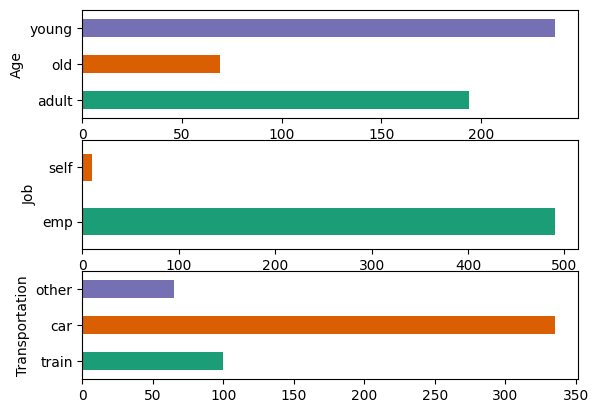

In [3]:
# Creating simple bar plot of certain variables
from matplotlib import pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(3, 1)
data.groupby('A').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ylabel="Age", ax=axs[0])
data.groupby('O').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ylabel="Job", ax=axs[1])
data['T'].value_counts().reindex(['train','car', 'other'], fill_value=0).plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'),ylabel="Transportation", ax=axs[2])

## Maximum Likelihood Estimation (MLE)

As detailed by [Robert Osazuwa Ness](https://www.amazon.com/Causal-AI-Robert-Ness/dp/1633439917): *MLE seeks the parameters/kernels that maximizes the likelihood of seeing the data we are using to train the model*. Which in our case is a Bayesian Network. Because the data we are using consists of categorical data, MLE calculates the probability distributions/Markov kernels by the proportion of counts in the data that staisfy a given critera. So for the CPD/kernel of $P(O=emp | E=high)$ it is calcualted as follows: $ \frac{\sum_{i}^{n}(O=emp\; and \;  E=high)}{\sum_{i}^{n}E=high}$

In [22]:
# using mle to get Markov kernels
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
import networkx as nx
# Building list of causal relationships
caus_real=[('A', 'E'),('S', 'E'),('E', 'O'),('E', 'R'),('O', 'T'),('R', 'T')]
# Building causal DAG from causal relationships
G = nx.DiGraph()
G.add_edges_from(caus_real)
model_mle = DiscreteBayesianNetwork(ebunch=G)
model_mle.fit(data=data, estimator=MaximumLikelihoodEstimator)
causal_markov_kernels = model_mle.get_cpds()
# displaying the CPD/Markov kernel for P(T| O, R)
cmk_T = causal_markov_kernels[1]
df = cmk_T.to_dataframe()
df

E            high       uni
A     S                    
adult F  0.518868  0.481132
      M  0.761364  0.238636
old   F  0.871795  0.128205
      M  0.900000  0.100000
young F  0.120690  0.879310
      M  0.768595  0.231405

## Bayesian Estimation

The Bayesian Estimation that is used by the [pgmpy](https://pgmpy.org/index.html) library relies upon using conjugate priors to calculate the posterior distribution.Pgmpy implements a [Dirichlet conjugate prior](https://en.wikipedia.org/wiki/Dirichlet_distribution) for categorical outcomes which makes sense since the Dirichlet distribution is the conjugate prior distribution of the categorical distribution which means that if a data point has a categorical distribution, and the prior distribution is distributed as a Dirichlet, then the posterior distribution of the parameters/kernels are also Dirichlet. This form of estimation will act like a smoothing mechanism to help alleviate biased/incomplete data in which extreme probability outcomes may occur (e.g., under MLE the probablity of taking a car in your daily commute when self-employed and living in a small region is 100% which is probably not true)

In [18]:
# using Bayes Estimation to get Markov kernels
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator
import networkx as nx
# Building list of causal relationships
caus_real=[('A', 'E'),('S', 'E'),('E', 'O'),('E', 'R'),('O', 'T'),('R', 'T')]
# Building causal DAG from causal relationships
G = nx.DiGraph()
G.add_edges_from(caus_real)
model = DiscreteBayesianNetwork(ebunch=G)
model.fit(data=data, estimator=BayesianEstimator,
          prior_type="dirichlet",
          pseudo_counts=1)
causal_markov_kernels = model.get_cpds()
# displaying the CPD/Markov kernel for P(T| O, R)
cmk_T = causal_markov_kernels[1]
df = cmk_T.to_dataframe()
df

E            high       uni
A     S                    
adult F  0.518519  0.481481
      M  0.755556  0.244444
old   F  0.853659  0.146341
      M  0.875000  0.125000
young F  0.127119  0.872881
      M  0.764228  0.235772

## Expectation Maximization (EM)

The Expectation Maximization (EM) algorithm is an iterative method to find the  maximum likelihood estimates (MLE) of parameters/kernels, *where the model depends on unobserved latent variables*. The EM algorithm alternates between performing an expectation (E) step, which creates a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters/kernels, and a maximization (M) step, which computes parameters/kernels maximizing the expected log-likelihood found in the E step. These parameter/kernel estimates are then used to determine the distribution of the latent variables in the next E step.

In [21]:
from pgmpy.estimators import ExpectationMaximization as EM
# removing the random variable E in the data
data_sans_E = data[['A', 'S', 'O', 'R', 'T']]
model_with_latent = DiscreteBayesianNetwork(
       [
        ('A', 'E'),
        ('S', 'E'),
        ('E', 'O'),
        ('E', 'R'),
        ('O', 'T'),
        ('R', 'T')
     ],
     latents={"E"}    #3 variable that is latent
)
estimator = EM(model_with_latent, data_sans_E)
cmks_with_latent = estimator.get_parameters(latent_card={'E': 2})
cmks_with_latent[3].to_dataframe()

  0%|          | 0/100 [00:00<?, ?it/s]

E               0         1
A     S                    
adult F  0.511505  0.488495
      M  0.428743  0.571257
old   F  0.753503  0.246497
      M  0.990468  0.009532
young F  0.038801  0.961199
      M  0.725146  0.274854

## Making Inferences using trained Bayesian Network

After the probabilistic machine learning model has been trained, it can be used for making inferences using inference algorithms to infer the CPD/Markov kernels of an outcome for any subset of the variables, given outcomes for the other variables. The inference algorithm used in this example for a Bayesian Network is [variable elimination](https://en.wikipedia.org/wiki/Variable_elimination). In this example we will use the variable elimination algorithm to infer the following CPD/Markov Kernel: $P(E|T)\;when\;T=train\; and\;T=car$ using the mle and Bayesian estimation methods.

In [29]:
from pgmpy.inference import VariableElimination
#mle
inference = VariableElimination(model_mle)
query1 = inference.query(['E'], evidence={"T": "train"})
query2 = inference.query(['E'], evidence={"T": "car"})
print("train_mle")
print(query1)
print("car_mle")
print(query2)
print("----------------------------")
#bayesian
inference = VariableElimination(model)
query1 = inference.query(['E'], evidence={"T": "train"})
query2 = inference.query(['E'], evidence={"T": "car"})
print("train_bayes")
print(query1)
print("car_bayes")
print(query2)

train_mle
+---------+----------+
| E       |   phi(E) |
+=========+==========+
| E(high) |   0.6209 |
+---------+----------+
| E(uni)  |   0.3791 |
+---------+----------+
car_mle
+---------+----------+
| E       |   phi(E) |
+=========+==========+
| E(high) |   0.5621 |
+---------+----------+
| E(uni)  |   0.4379 |
+---------+----------+
----------------------------
train_bayes
+---------+----------+
| E       |   phi(E) |
+=========+==========+
| E(high) |   0.6162 |
+---------+----------+
| E(uni)  |   0.3838 |
+---------+----------+
car_bayes
+---------+----------+
| E       |   phi(E) |
+=========+==========+
| E(high) |   0.5586 |
+---------+----------+
| E(uni)  |   0.4414 |
+---------+----------+
